In [ ]:
!git clone https://github.com/zhn66776/Tidal_try.git

Cloning into 'Tidal_try'...
remote: Enumerating objects: 675, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 675 (delta 172), reused 249 (delta 133), pack-reused 355 (from 1)
Receiving objects: 100% (675/675), 81.98 MiB | 14.30 MiB/s, done.
Resolving deltas: 100% (303/303), done.


In [ ]:
cd Tidal_try

/content/Tidal_try


Selected start index: 121958
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training BiGRU_2feat...
Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.4026 - val_loss: 0.1165 - learning_rate: 0.0010
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.1023 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0802 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0696 - val_loss: 0.0639 - learning_rate: 0.0010
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0606 - val_loss: 0.0560 - learning_rate: 0.0010
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0530 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0464 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0408 - val_

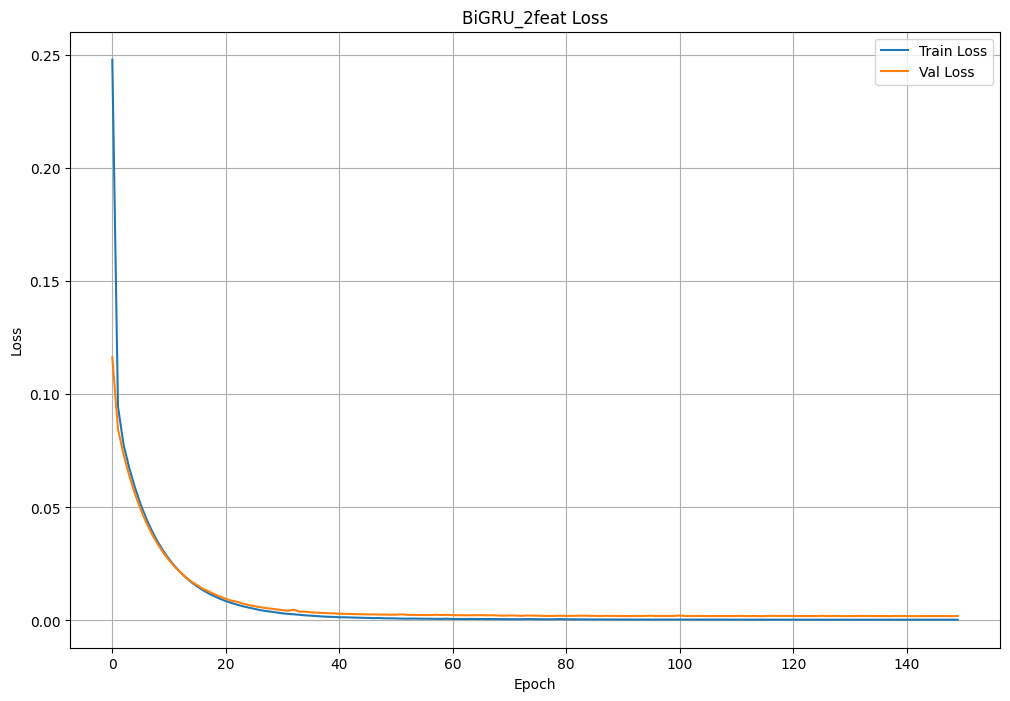

Performing rolling prediction with BiGRU_2feat...
BiGRU_2feat rolling prediction completed.



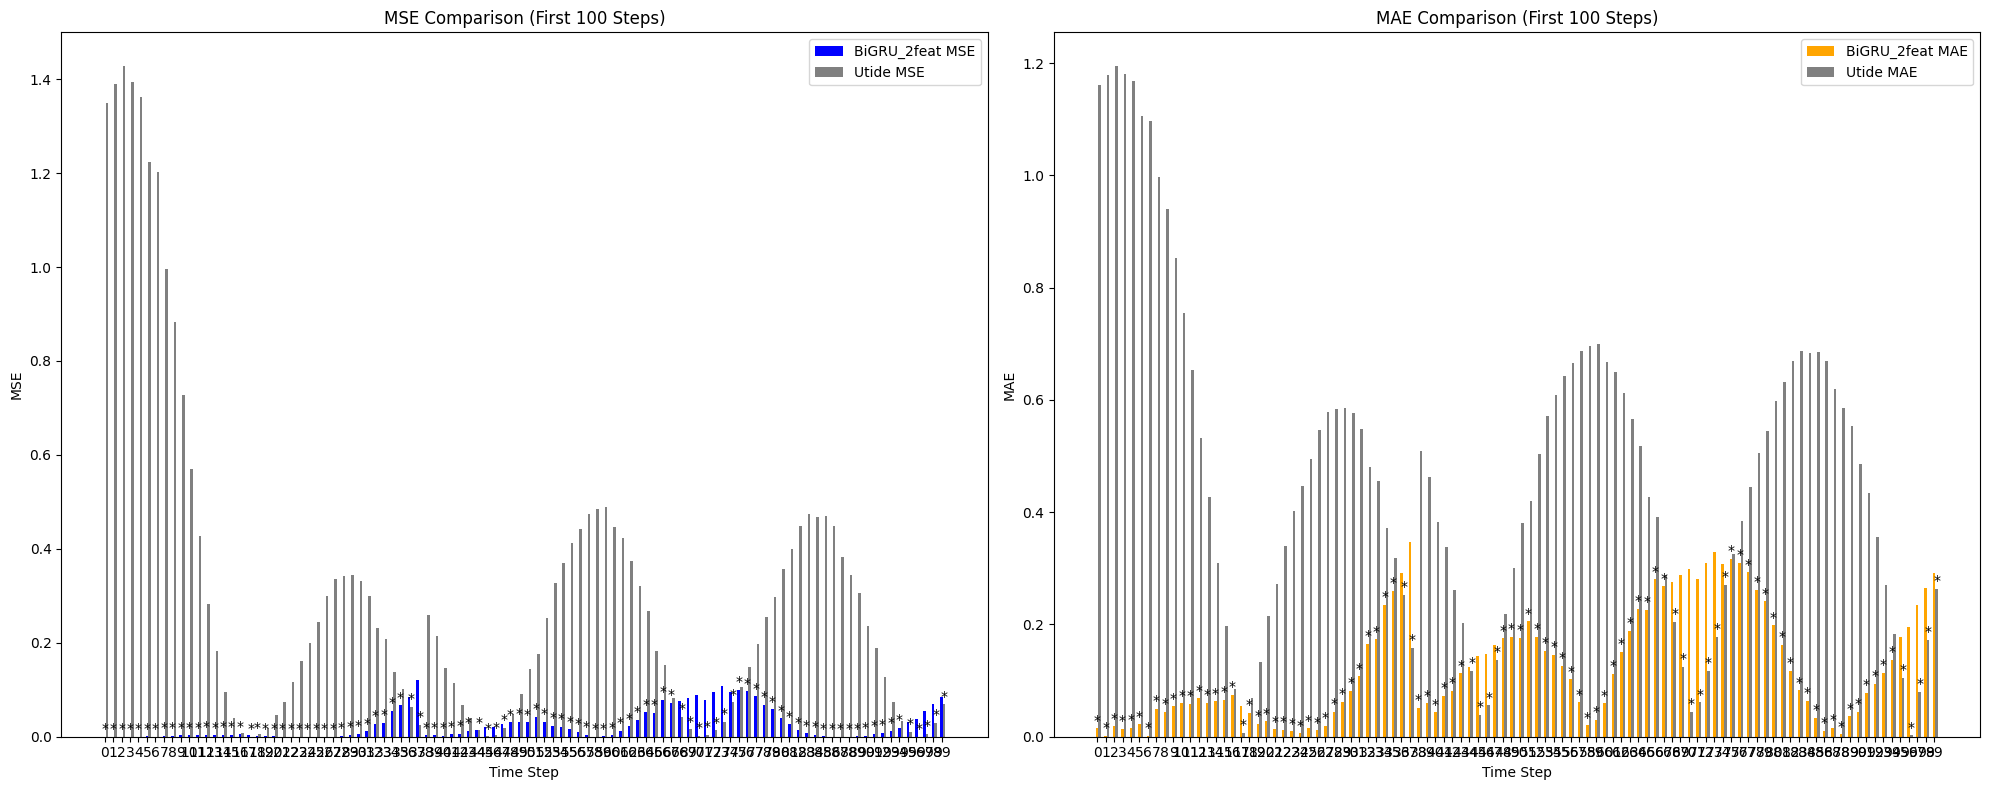

BiGRU_2feat R² falls below Utide at step: Never


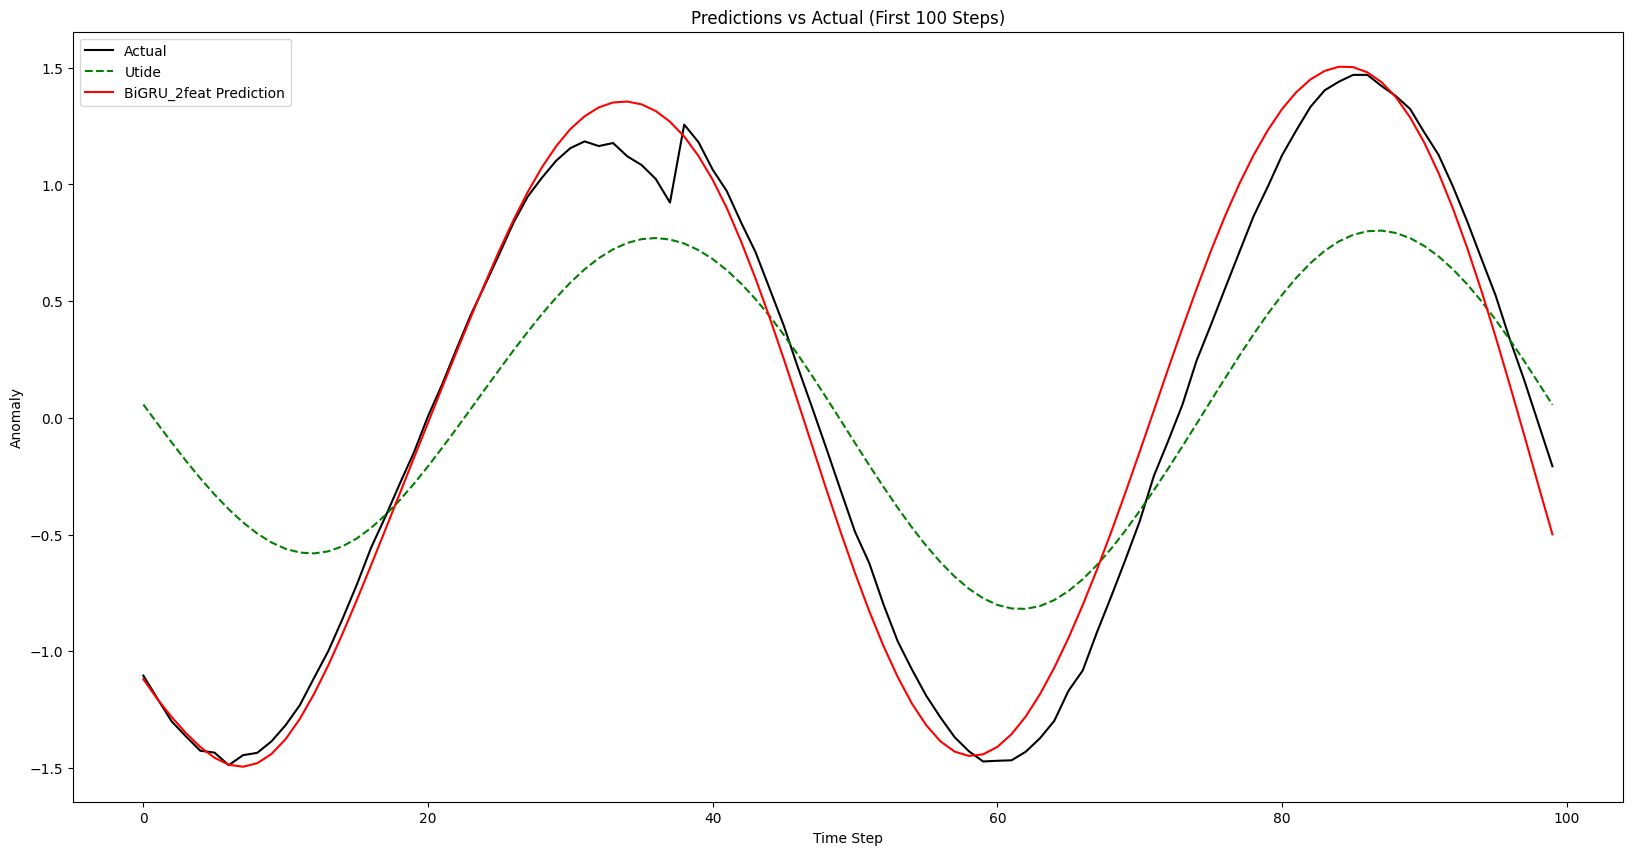

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Model
from keras.layers import Dense, GRU, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

utide_factor = 0.5
utide = utide * utide_factor

scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_multi = 2

# bigru
def build_bigru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(700, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

model = build_bigru_multi((look_back_points, num_features_multi))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 150
batch_size = 256

print("Training BiGRU_2feat...")
history = model.fit(trainX_multi, trainY_multi,
                    validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr])
print("BiGRU_2feat training completed.\n")

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiGRU_2feat Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# rolling
def rolling_prediction_multi(model, test, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]
        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

print("Performing rolling prediction with BiGRU_2feat...")
results = rolling_prediction_multi(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
print("BiGRU_2feat rolling prediction completed.\n")

actual_values_full = scaler_anomaly.inverse_transform(
    test_multi[look_back_points:look_back_points + total_test_points, 0].reshape(-1,1)).flatten()
utide_values_full = scaler_utide.inverse_transform(
    test_multi[look_back_points:look_back_points + total_test_points, 1].reshape(-1,1)).flatten()

r2_utide = r2_score(actual_values_full, utide_values_full)

# plot MSE、MAE
steps_to_plot = 100
x = np.arange(steps_to_plot)
width = 0.3

actual = results['actual_values'][:steps_to_plot]
predicted = results['predicted_values'][:steps_to_plot]
mse = (actual - predicted)**2
mae = np.abs(actual - predicted)

mse_utide = (actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])**2
mae_utide = np.abs(actual_values_full[:steps_to_plot] - utide_values_full[:steps_to_plot])

fig, axes = plt.subplots(1,2, figsize=(20,8))

# MSE
axes[0].bar(x, mse, width, label='BiGRU_2feat MSE', color='blue')
axes[0].bar(x + width, mse_utide, width, label='Utide MSE', color='grey')
axes[0].set_title('MSE Comparison (First 100 Steps)')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mse[i], mse_utide[i]]
    min_idx = np.argmin(errors)
    min_x = x[i] if min_idx == 0 else x[i] + width
    axes[0].text(min_x, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

# MAE
axes[1].bar(x, mae, width, label='BiGRU_2feat MAE', color='orange')
axes[1].bar(x + width, mae_utide, width, label='Utide MAE', color='grey')
axes[1].set_title('MAE Comparison (First 100 Steps)')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].set_xticks(x)

for i in range(steps_to_plot):
    errors = [mae[i], mae_utide[i]]
    min_idx = np.argmin(errors)
    min_x = x[i] if min_idx == 0 else x[i] + width
    axes[1].text(min_x, errors[min_idx] + 0.001, '*', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# time tat r2 lower Utide
start_index_plot = 0
n_steps_plot = 300
indices = np.arange(start_index_plot, min(start_index_plot + n_steps_plot, total_test_points))

model_r2 = results['r2_scores'][indices]
falloff_indices = np.where(model_r2 < r2_utide)[0]
first_falloff = falloff_indices[0] if falloff_indices.size > 0 else "Never"
print(f"BiGRU_2feat R² falls below Utide at step: {first_falloff}")


plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black')
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--')
plt.plot(predicted, label='BiGRU_2feat Prediction', color='red')
plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Dense, GRU, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small. Required: {total_required}, Current: {len(df)}")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide = df_sampled['utide'].values.reshape(-1, 1)

utide_factor = 0.5
utide = utide * utide_factor

scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))
utide_scaled = scaler_utide.fit_transform(utide)

dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))
train_multi = dataset_scaled_multi[:total_train_points]
test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

print("Multi-feature TrainX:", trainX_multi.shape, "TrainY:", trainY_multi.shape)
print("Multi-feature TestX:", testX_multi.shape, "TestY:", testY_multi.shape)

num_features_multi = 2

# bigru
def build_bigru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(700, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

model = build_bigru_multi((look_back_points, num_features_multi))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

epochs = 150
batch_size = 256

print("Training BiGRU_2feat...")
history = model.fit(trainX_multi, trainY_multi,
                    validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    callbacks=[reduce_lr])
print("BiGRU_2feat training completed.\n")

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('BiGRU_2feat Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#rolling
def rolling_prediction_multi(model, test, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    r2_scores = []
    utide_r2_scores = []

    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]
        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]

        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

        if i >= 20:
            r2_scores.append(r2_score(actual_values, rolling_predictions))
            utide_r2_scores.append(r2_score(actual_values, utide_values))
        else:
            r2_scores.append(np.nan)
            utide_r2_scores.append(np.nan)

    return {
        'actual_values': np.array(actual_values),
        'predicted_values': np.array(rolling_predictions),
        'utide_values': np.array(utide_values),
        'r2_scores': np.array(r2_scores),
        'utide_r2_scores': np.array(utide_r2_scores)
    }

print("Performing rolling prediction with BiGRU_2feat...")
results = rolling_prediction_multi(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
print("BiGRU_2feat rolling prediction completed.\n")

actual_values_full = scaler_anomaly.inverse_transform(
    test_multi[look_back_points:look_back_points + total_test_points, 0].reshape(-1,1)).flatten()
utide_values_full = scaler_utide.inverse_transform(
    test_multi[look_back_points:look_back_points + total_test_points, 1].reshape(-1,1)).flatten()

#r2、MSE、MAE

r2 = r2_score(actual_values_full, results['predicted_values'])
mse_300 = mean_squared_error(actual_values_full[:300], results['predicted_values'][:300])
mae_300 = mean_absolute_error(actual_values_full[:300], results['predicted_values'][:300])

print(f"R²: {r2:.4f}, MSE (First 300 Steps): {mse_300:.4f}, MAE (First 300 Steps): {mae_300:.4f}")

# 绘制预测对比图
plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:100], label='Actual', color='black')
plt.plot(utide_values_full[:100], label='Utide', color='green', linestyle='--')
plt.plot(results['predicted_values'][:100], label='BiGRU_2feat Prediction', color='red')
plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('Predictions vs Actual (First 100 Steps)')
plt.legend()
plt.show()

Selected start index: 121958
Multi-feature TrainX: (9900, 100, 2) TrainY: (9900,)
Multi-feature TestX: (2000, 100, 2) TestY: (2000,)
Training BiGRU_2feat...
Epoch 1/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.4164 - val_loss: 0.1180 - learning_rate: 0.0010
Epoch 2/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.1035 - val_loss: 0.0858 - learning_rate: 0.0010
Epoch 3/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0815 - val_loss: 0.0745 - learning_rate: 0.0010
Epoch 4/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0709 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 5/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 0.0620 - val_loss: 0.0575 - learning_rate: 0.0010
Epoch 6/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0545 - val_loss: 0.0507 - learning_rate: 0.0010
Epoch 7/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0480 - val_loss: 0.0448 - learning_rate: 0.0010
Epoch 8/150
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0423 - val_

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-316e23e5244c>", line 94, in <cell line: 94>
    history = model.fit(trainX_multi, trainY_multi,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit
    logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 833, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/pyth


KeyboardInterrupt



# 10 times of rolling forcasting with different weight of utide (0.6 0.7)

Selected start index: 146867
Training with utide_factor=1.0
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - loss: 0.3050 - val_loss: 0.0944 - learning_rate: 0.0010
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0846 - val_loss: 0.0658 - learning_rate: 0.0010
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0641 - val_loss: 0.0558 - learning_rate: 0.0010
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0546 - val_loss: 0.0478 - learning_rate: 0.0010
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0469 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0404 - val_loss: 0.0354 - learning_rate: 0.0010
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0349 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0303 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 9/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0263 - 

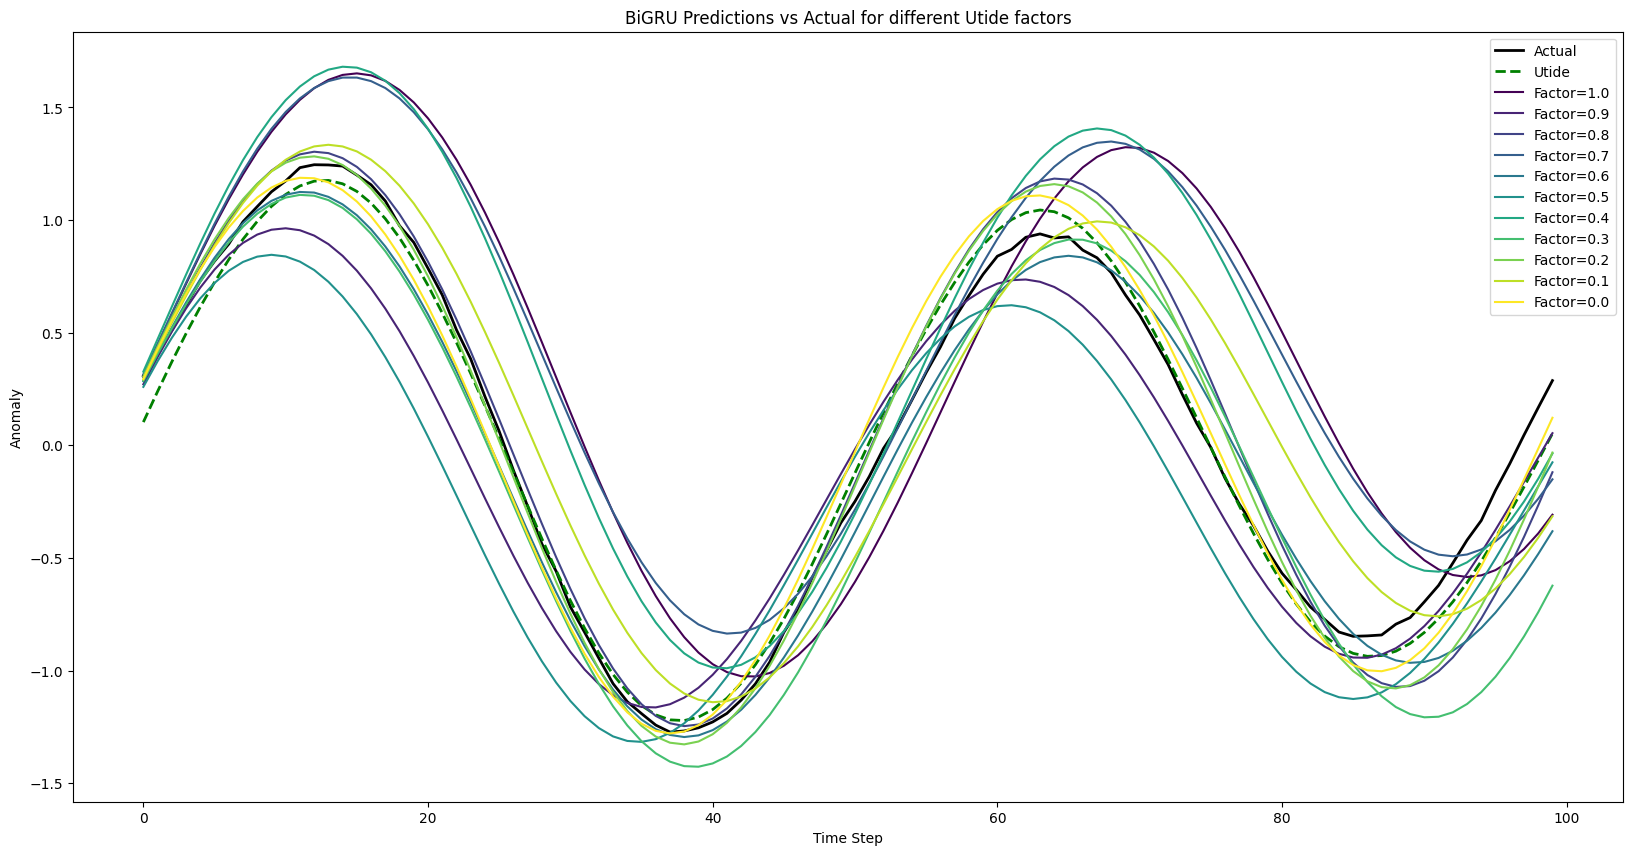

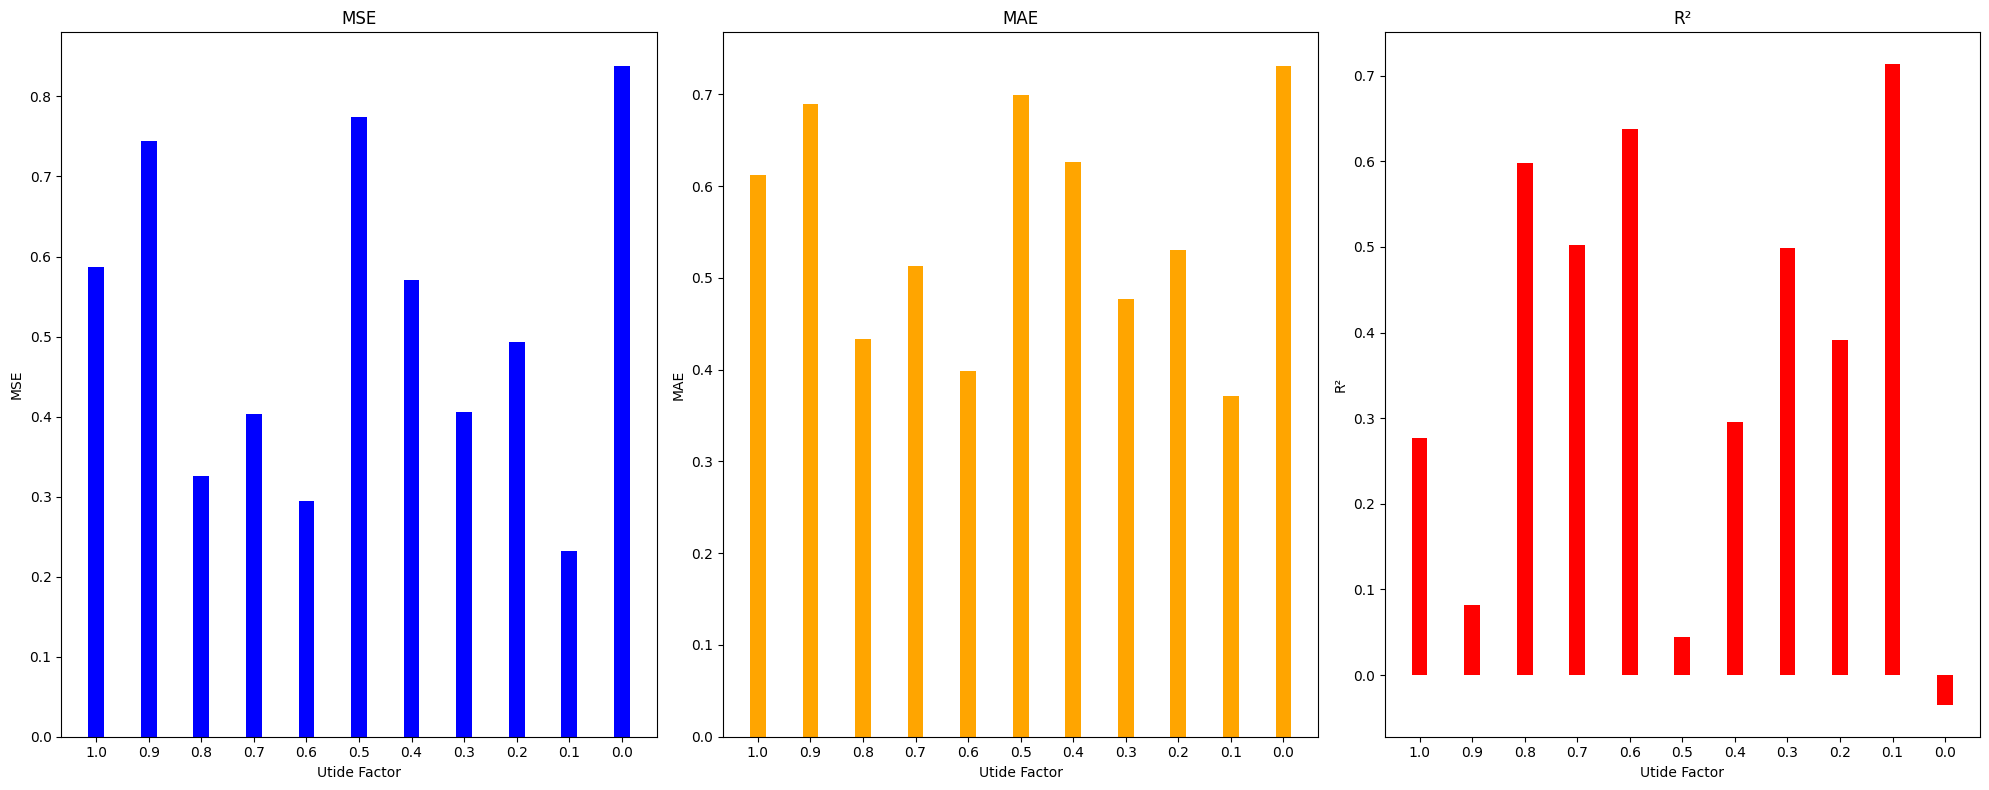

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Model
from keras.layers import Dense, GRU, Dropout, Bidirectional, Input
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings
from sklearn.exceptions import UndefinedMetricWarning
import tensorflow as tf

# np.random.seed(42)
# tf.random.set_seed(42)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


input_file = "dataProcessed/ABE5Y1_HA_processed.csv"
df = pd.read_csv(input_file, delimiter=',')
total_train_points = 10000
look_back_points = 100
total_test_points = 2000

total_required = total_train_points + look_back_points + total_test_points
if len(df) < total_required:
    raise ValueError(f"Dataset too small.")

max_start_index = len(df) - total_required
start_index = np.random.randint(0, max_start_index + 1)
print(f"Selected start index: {start_index}")

df_sampled = df.iloc[start_index:start_index + total_required].reset_index(drop=True)

anomaly = df_sampled['anomaly'].values.reshape(-1, 1)
utide_original = df_sampled['utide'].values.reshape(-1, 1)

scaler_anomaly = MinMaxScaler(feature_range=(0, 1))
anomaly_scaled = scaler_anomaly.fit_transform(anomaly)

scaler_utide = MinMaxScaler(feature_range=(0, 1))

def create_dataset_multi(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    return np.array(dataX), np.array(dataY)

def build_bigru_multi(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(GRU(500, return_sequences=True, kernel_regularizer=l2(0.0001)))(input_layer)
    x = Dropout(0.3)(x)
    x = Bidirectional(GRU(500, kernel_regularizer=l2(0.0001)))(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001))
    return model

def rolling_prediction_multi(model, test, scaler_anomaly, scaler_utide, look_back):
    total_tp = len(test) - look_back
    current_input = test[:look_back].copy()
    rolling_predictions = []
    actual_values = []
    utide_values = []
    for i in range(total_tp):
        input_sequence = current_input.reshape(1, look_back, 2)
        prediction = model.predict(input_sequence, verbose=0)
        predicted_anomaly_scaled = prediction[0, 0]

        actual_anomaly_scaled = test[look_back + i, 0]
        actual_anomaly = scaler_anomaly.inverse_transform([[actual_anomaly_scaled]])[0, 0]
        actual_values.append(actual_anomaly)

        utide_scaled_val = test[look_back + i, 1]
        utide_val = scaler_utide.inverse_transform([[utide_scaled_val]])[0, 0]
        utide_values.append(utide_val)

        predicted_anomaly = scaler_anomaly.inverse_transform([[predicted_anomaly_scaled]])[0,0]
        rolling_predictions.append(predicted_anomaly)

        current_input = np.roll(current_input, -1, axis=0)
        if i < total_tp - 1:
            next_utide_scaled = test[look_back + i + 1, 1]
        else:
            next_utide_scaled = test[look_back + i, 1]
        current_input[-1, 0] = predicted_anomaly_scaled
        current_input[-1, 1] = next_utide_scaled

    return np.array(actual_values), np.array(rolling_predictions), np.array(utide_values)

utide_factors = np.linspace(1.0, 0.0, 11)

all_predictions = []
all_mse = []
all_mae = []
all_r2 = []

actual_values_full = None
utide_values_full = None

for factor in utide_factors:
    print(f"Training with utide_factor={factor:.1f}")
    utide = utide_original * factor
    utide_scaled = scaler_utide.fit_transform(utide)
    dataset_scaled_multi = np.hstack((anomaly_scaled, utide_scaled))
    train_multi = dataset_scaled_multi[:total_train_points]
    test_multi = dataset_scaled_multi[total_train_points : total_train_points + total_test_points + look_back_points]

    trainX_multi, trainY_multi = create_dataset_multi(train_multi, look_back_points)
    testX_multi, testY_multi = create_dataset_multi(test_multi, look_back_points)

    model = build_bigru_multi((look_back_points, 2))

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)

    epochs = 50
    batch_size = 256

    model.fit(trainX_multi, trainY_multi,
              validation_split=0.1,
              epochs=epochs,
              batch_size=batch_size,
              verbose=1,
              callbacks=[reduce_lr])

    actual_values, predictions, utide_values = rolling_prediction_multi(model, test_multi, scaler_anomaly, scaler_utide, look_back_points)
    if actual_values_full is None:
        actual_values_full = actual_values
        utide_values_full = utide_values

    mse_val = mean_squared_error(actual_values, predictions)
    mae_val = mean_absolute_error(actual_values, predictions)
    r2_val = r2_score(actual_values, predictions)

    all_predictions.append(predictions)
    all_mse.append(mse_val)
    all_mae.append(mae_val)
    all_r2.append(r2_val)

steps_to_plot = 100
plt.figure(figsize=(20,10))
plt.plot(actual_values_full[:steps_to_plot], label='Actual', color='black', linewidth=2)
plt.plot(utide_values_full[:steps_to_plot], label='Utide', color='green', linestyle='--', linewidth=2)

colors = plt.cm.viridis(np.linspace(0,1,len(utide_factors)))
for i, factor in enumerate(utide_factors):
    plt.plot(all_predictions[i][:steps_to_plot], label=f'Factor={factor:.1f}', color=colors[i])

plt.xlabel('Time Step')
plt.ylabel('Anomaly')
plt.title('BiGRU Predictions vs Actual for different Utide factors')
plt.legend()
plt.show()

x = np.arange(len(utide_factors))
width = 0.3

fig, axes = plt.subplots(1,3, figsize=(20,8))

# MSE
axes[0].bar(x, all_mse, width, color='blue')
axes[0].set_title('MSE')
axes[0].set_xlabel('Utide Factor')
axes[0].set_ylabel('MSE')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f"{f:.1f}" for f in utide_factors])

# MAE
axes[1].bar(x, all_mae, width, color='orange')
axes[1].set_title('MAE')
axes[1].set_xlabel('Utide Factor')
axes[1].set_ylabel('MAE')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f"{f:.1f}" for f in utide_factors])

# R²
axes[2].bar(x, all_r2, width, color='red')
axes[2].set_title('R²')
axes[2].set_xlabel('Utide Factor')
axes[2].set_ylabel('R²')
axes[2].set_xticks(x)
axes[2].set_xticklabels([f"{f:.1f}" for f in utide_factors])

plt.tight_layout()
plt.show()